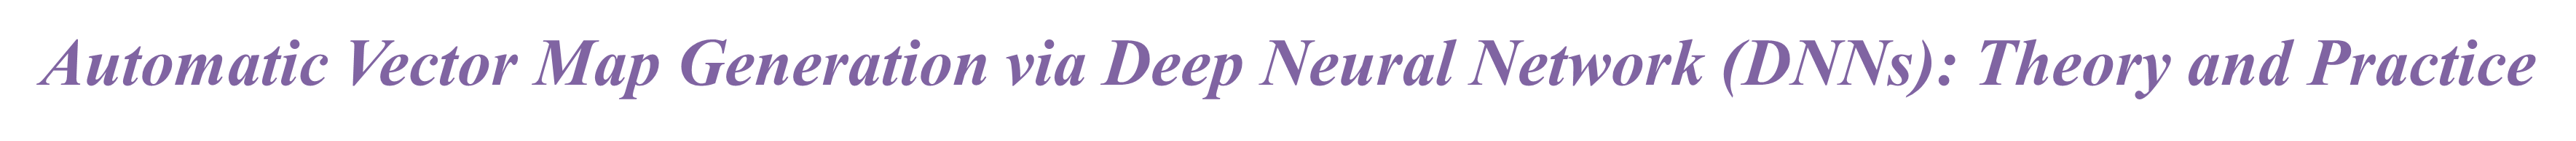

This notebook shows binary **BUILDING SEGMENTATION** in **Tensorflow-Keras** farmework. We will use a custom dataset from Yazd province of Iran. This task will classify pixel of input image as **BUILDING** or **NON-BUILDING**.

This notebook contains four section:

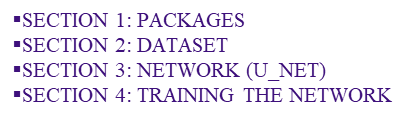



[Colaboratory](https://colab.research.google.com/)





*   online representation of jupyter notebook





*   Data analysis and machine learning tool 

*   Allows to combine Python code and text along with charts, images, HTML, LaTeX

*   Enable to connect google drive folders
*   It connects to Google Cloud Platform runtimes 

*   Access to GPUs free of charge

*   Enable to share your work and collaborate with other easily

*   Pre-Installed Libraries
*   Install required libraries: !pip install library-name

*   Three types of runtime for Google Colab:CPU, TPU, GPU

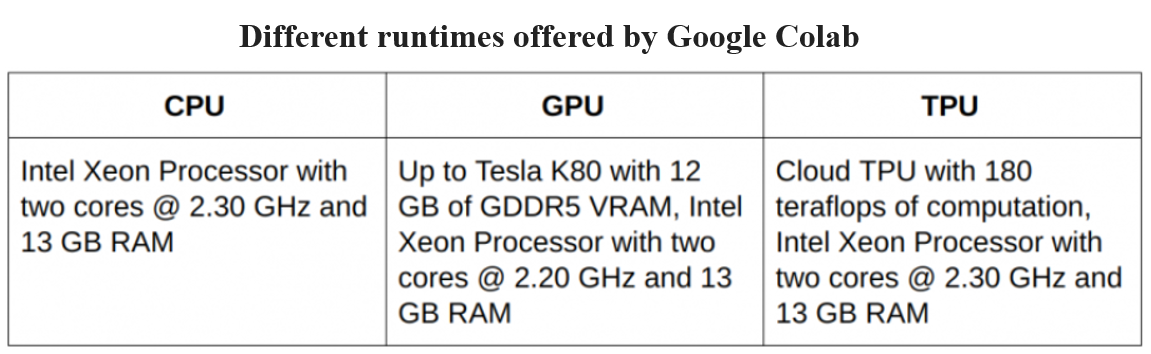


















##   SECTION 1: PACKAGES


Package Introduction

[Rasterio](https://rasterio.readthedocs.io/en/latest/)   

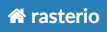
*  To write and read GeoTIFF and other formats
*  to organize and store gridded raster datasets such as satellite imagery and terrain models.








---



---


[Numpy](https://numpy.org/)

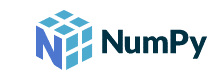
* Used for working with arrays
* Various derived objects (such as masked arrays and matrices), shape manipulation, sorting, selecting
* It has functions for working in the domain of linear algebra, Fourier transform, and matrices



---



---


[Matplotlib](https://matplotlib.org/)


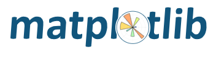

* Comprehensive library for creating static, animated, and interactive visualizations in Python
* [matplotlib.pyplot](https://matplotlib.org/stable/api/pyplot_summary.html#module-matplotlib.pyplot) is a collection of functions that make matplotlib works like MATLAB
* creates a figure, 
* creates a plotting area in a figure
* plots some lines in a plotting area
* plot with labels
* Plot charts with Legend





---



---


[Cv2](https://opencv.org/)

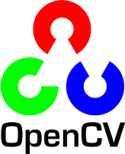

* Used for image processing and performing computer vision tasks.
* Face detection
* Objection tracking






---



---


[Glob](https://docs.python.org/3/library/glob.html)

* Returns an array of filenames or directories matching a specified pattern



---





[Random](https://docs.python.org/3/library/random.html)


* A function for generating random samples



---





[Scikit-learn](https://scikit-learn.org/stable/)

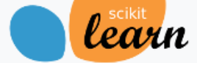

* Simple and efficient tools for predictive data analysis





---


[Tensorflow](https://www.tensorflow.org/)

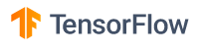


* open-source library for fast numerical computing
* created by Google for the Python programming language
* An end-to-end machine learning platform
* best practices for data automation, model tracking, performance monitoring, and model retraining



---

[Keras](https://keras.io/)

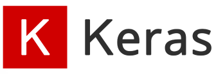


* High-level, deep learning API developed by Google for implementing neural networks
* Written in Python 
* Supports multiple backend neural network computation. Exp:Tensorflow                    
* Easy to learn and work and slow
* Beginner-friendly

**Tensorflow vs Keras:**
* TensorFlow is an open-sourced end-to-end platform, a library for multiple machine-learning tasks
* Keras is a high-level neural network library that runs on top of TensorFlow.
Both provide high-level APIs used for quickly building and training models
Keras is more user-friendly


### Import packages

In [1]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 48.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import rasterio
import cv2
import random

from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score    # jaccard_score = IOU
from sklearn.metrics import recall_score


import tensorflow as tf
from keras.models import Model,load_model
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose, BatchNormalization, Activation
from keras.optimizers import Adam


# SECTION 2: DATASET
Our Dataset includes RGBD images and corresponding annotated images (Ground Truth or labels).  


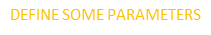

In [3]:
image_shape = (512,512,4)
label_shape = (512,512,1)

epoch = 50
batch_size = 2

num_class = 1  # building

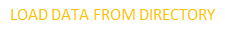

CONNECT TO GOOGLE DRIVE 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
train_RGBD = glob.glob('/content/drive/MyDrive/Data_complete/train/RGBD/Images/*.tif')
train_MAP = glob.glob('/content/drive/MyDrive/Data_complete/train/MAP/Images/*.tif')



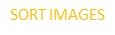

**Why we should sort the images?**

**Windows** sorts images based on name or sth like that.

**Linux (Colab)** sorts images based on time it got added.

In [29]:
train_RGBD.sort()
train_MAP.sort()


In [30]:
path_TRAIN_RGBD = train_RGBD[0:80]
path_TRAIN_MAP = train_MAP[0:80]

path_VAL_RGBD = train_RGBD[80:100]
path_VAL_MAP = train_MAP[80:100]


In [31]:
print('Number of training images: {} '.format(len(path_TRAIN_RGBD)))
print('Number of validation images: {} '.format(len(path_VAL_RGBD)))

print('Number of training labels: {} '.format(len(path_TRAIN_MAP)))
print('Number of validation labels: {} '.format(len(path_VAL_MAP)))

Number of training images: 80 
Number of validation images: 20 
Number of training labels: 80 
Number of validation labels: 20 


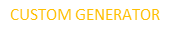

To read 4D RGBD images we define a custum generator. It can generate data in shape of (batch_size, image_width, image_height, channel).

In [32]:
  
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self,
                 paths_list,
                 batch_size,
                 epoch,
                 target_size=(512, 512),
                 MAP = False,      # different way to read RGBD and Map
                 RGBD=False):
        
        self.epoch = epoch
        self.batch_size = batch_size
        self.paths_list = paths_list
        self.target_size = target_size
        self.n = len(paths_list)
        self.MAP = MAP
        self.RGBD = RGBD
       
      
    
    def __get_input(self, path, target_size):
      # read RGBD images and GT
          #GT
        if self.MAP:
            image = rasterio.open(path).read()    # shape = [number of chennel, height, width], dtype = float32
            image = np.rollaxis(image, 0, 3)
            # if MAPs are in png format
            # image = cv2.imread(path)    # dtype = uint8
            # convert_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)   # conver RGB To Grayscale image , dtype = float32, shape  = [height, width]  
            # image = convert_image[..., np.newaxis]   # shape = [height, width, 1]
            method = 'nearest'
          #RGBD  
        elif self.RGBD:
            image = rasterio.open(path).read()    # shape = [number of chennel, height, width], dtype = float32
            image = np.rollaxis(image, 0, 3)      # shape = [height, width, number of chennel], dtype = float32
            method = 'bilinear'
            # Resize RGBD image and GT
        image = tf.image.resize(image,(target_size[0], target_size[1]), method=method).numpy()
        
        return image

    
    def __get_data(self, batch_path):
        # Generates data containing batch_size samples
        # don't read all images at ones
        
        X_batch = np.asarray([self.__get_input(image_path, self.target_size) for image_path in batch_path])

        return X_batch
    
    def __getitem__(self, index):
        # get the index of list                               # image = [image1, image2, image3, image4]
        i = (index*self.batch_size) % self.n                  # e.g. index = 1  number of training image is 90 => (1x2) % 90 = 2     % return the remainder of dividing
        batch_path = self.paths_list[i:i+self.batch_size]     # batch_path = path_list [2 : 2+2]
        X = self.__get_data(batch_path)        
        return X
    
    def __len__(self):
      # How many images does the custom generator generate?
                                                               # epoch = 50, number of images = 90, batch_size = 2
        return  self.epoch*self.n // self.batch_size           # e.g.  50 * 90 // 2 = 2250    // is Floor division that returns the largest possible integer
    

***Generate training and test dataset from directory using Custom Generator***

In [33]:
rgbd_train_gen = CustomDataGen(path_TRAIN_RGBD, batch_size=batch_size, epoch=epoch, RGBD=True)
GT_train_gen = CustomDataGen(path_TRAIN_MAP, batch_size=batch_size, epoch=epoch, MAP=True)

rgbd_val_gen =  CustomDataGen(path_VAL_RGBD, batch_size=batch_size, epoch=epoch, RGBD=True)
GT_val_gen =  CustomDataGen(path_VAL_MAP, batch_size=batch_size, epoch=epoch, MAP=True)

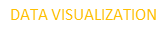

In [36]:
# generate a random digit to show/plot some samples
batch_number = random.randint(0, len(path_TRAIN_RGBD)-1)


the RGBD batch shape is (2, 512, 512, 4)
the Ground Truth batch shape is (2, 512, 512, 1)


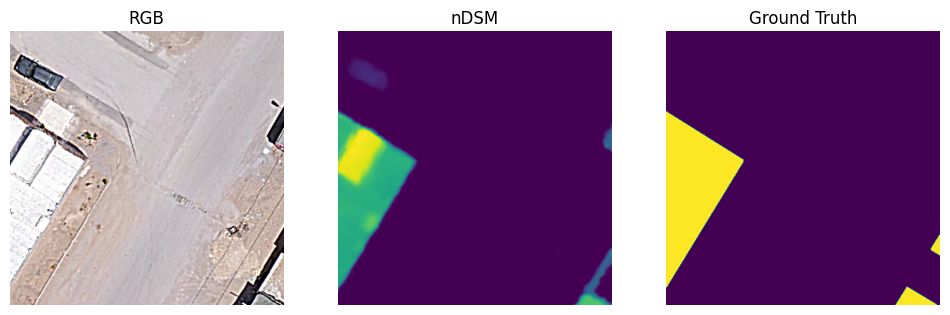

In [37]:
# get the random RGBD and MAP (GT)
x = rgbd_train_gen[batch_number]
print('the RGBD batch shape is {}'.format(x.shape))

y = GT_train_gen[batch_number]
print('the Ground Truth batch shape is {}'.format(y.shape))


# plot using matplotlib
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
axes = axes.ravel()

axes[0].imshow(x[0,..., 0:3])
axes[0].title.set_text('RGB')
axes[0].axis('off')

axes[1].imshow(x[0,..., 3])
axes[1].title.set_text('nDSM')
axes[1].axis('off')

axes[2].imshow(y[0, ... , 0])
axes[2].title.set_text('Ground Truth')
axes[2].axis('off')


None


# SECTION 3: NETWORK (U_NET)  

### **Functions Introduction**

[Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/)

* Creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.

* padding: one of "valid" or "same."
** "valid": no padding.
** "same": with zeros to the inputs left/right or up/down.
* padding= "same" and strides=1, the output has the same size as the input.
* Input shape: (batch size, rows, cols, channel)
* Output shape: activation(conv2d(inputs, kernel) + bias)
* Kernel_initializer=‘glorot_uniform'
* Bias_initializer=‘zeros’



---

---
[BatchNormailzation](https://keras.io/api/layers/normalization_layers/batch_normalization/)

* Layer that normalizes its inputs
* The mean output is close to 0, and the output standard deviation is close to 1

* make training of artificial neural networks faster and more stable

* Allows higher learning rates
* It makes weights easier to initialize 
* Simplifies the creation of deeper networks 
* It may give better results overall



---
[Activation](https://keras.io/api/layers/activations/)
* Sigmoid
* Softmax
* ReLu
* Tanh


---


---

[MaxPooling](https://keras.io/api/layers/pooling_layers/max_pooling2d/)

* Maxpooling(pool_size, strides, padding)
* It is a pooling operation that calculates the maximum value for patches of a feature map
* It uses it to create a downsampled (pooled) feature map.
* It is usually used after a convolutional layer


---



---



[Conv2DTranspose](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/)


* Conv2DTranspose(num_filters, kernel_size,  strides, padding)













---
[Concatenate](https://keras.io/api/layers/merging_layers/concatenate/)
* Layer that concatenates a list of inputs.
* It takes as input a list of tensors, all of the same shape except for the concatenation axis, and returns a single tensor that is the concatenation of all inputs.

---

---










## U-Net architecture

Building Unet by dividing encoder and decoder into blocks

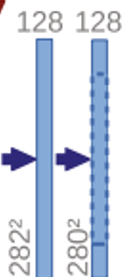

In [13]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)                       # * Conv2D(filters, strides, padding)
    x = BatchNormalization()(x)                                             #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)                                              #Not in the original network
    x = Activation("relu")(x)

    return x

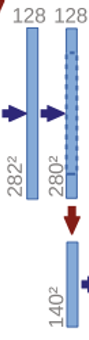

In [14]:
#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p  

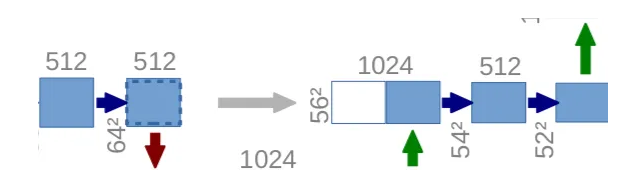

In [15]:
#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)      # Conv2DTranspose(num_filters, kernel_size, strides, padding)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


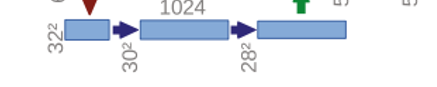

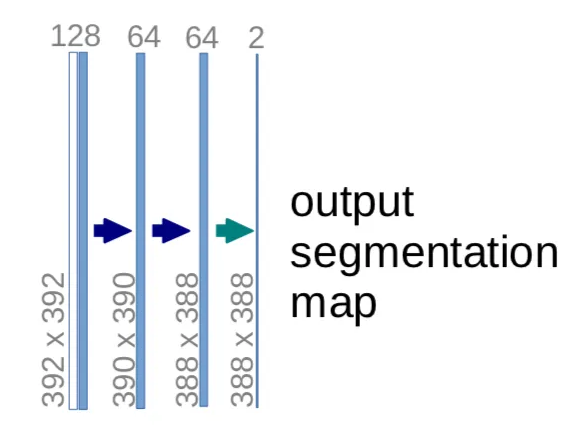

In [16]:
#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)
    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bridge
    b1 = conv_block(p4, 1024)                       
    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)


    outputs = Conv2D(n_classes, 1, padding="same", activation='sigmoid')(d4)              #Change the activation based on n_classes


    model = Model(inputs, outputs, name="U-Net")
    return model

[Compile](https://keras.io/api/models/model_training_apis/)

* Configures the model for training.
*[Optimizer](https://keras.io/api/optimizers/)
** SGD
**RMSprop
** Adam
** Adadelta

* Loss
** Probabilistic losses: Will be used on classification problems where the output is between 0 and 1. (Image Classification
BinaryCrossentropy class
* Metrics
** **Accuracy**: shows how the model performs across all classes.
** **Precision**: What percentage is truly positive out of all the positives predicted?
** **Recall**: Out of the total positive, what percentage are predicted positive?


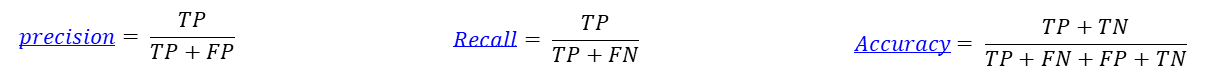



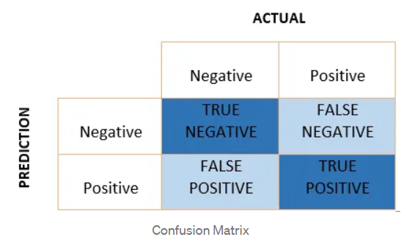


In [17]:
model = build_unet(image_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-4), loss='binary_crossentropy', metrics=['accuracy', 'Recall', 'Precision'])

Spatial Dimention of Output Feature Map

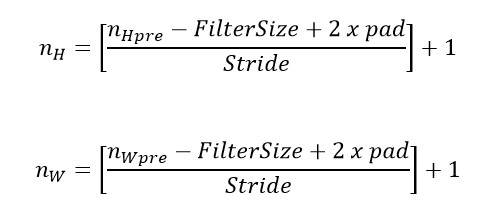

Nhpre: Height of previous layer


Nwpre: width of previous layer


pad = 'same'
Spatial dimention of conv2d_1: [(512 - 3 + 2 x pad)/2] + 1 = 512
                                 == >  pad = 252






Number of parameter for one layer: 

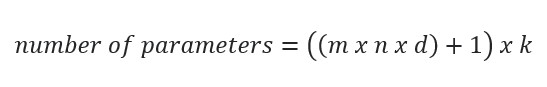

m = shape of the width of filter


n = shape of the height of the filter


d = number of filters in the previous layer


k = number of filters in the current layer



The number of parameters for the layer conv2d_1 : (3x3x64+1)x64 = 36928 



In [18]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  2368        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

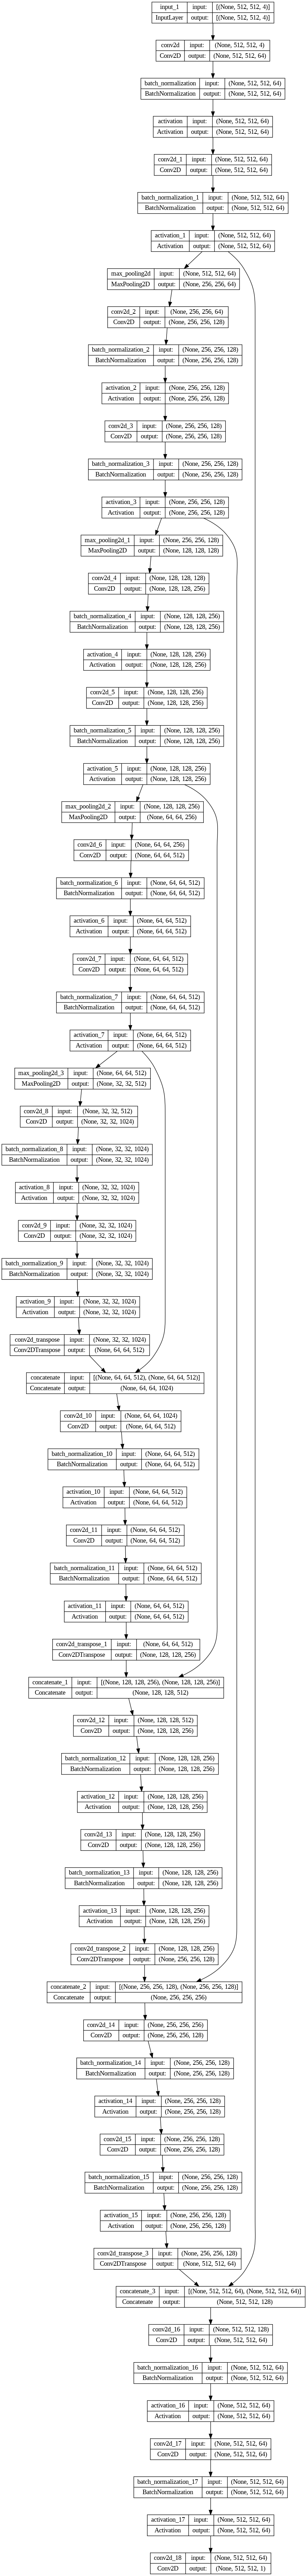

In [19]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

# SECTION 4:TRAINING THE NETWORK

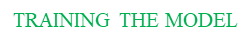

---
[Fit](https://keras.io/api/models/model_training_apis/)


* Batch size: Number of samples per gradient update.
* Epochs: Integer. A number of epochs to train the model.
* verbose: 'auto', 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
* shuffle: Boolean (whether to shuffle the training data before each epoch) 
* steps_per_epoch: Total number of steps (batches of samples) before declaring one epoch finished and starting the next.
* validation_steps: Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch



---

In [38]:
history = model.fit(
    x = zip(rgbd_train_gen, GT_train_gen),
    batch_size = batch_size,
    epochs = 5,
    verbose = 1,
    shuffle = True,
    validation_data = zip(rgbd_val_gen, GT_val_gen),
    steps_per_epoch = rgbd_train_gen.n // batch_size,        
    validation_steps = rgbd_val_gen.n // batch_size - 1,
    )

Epoch 1/5
40/40 [==============================] - 47s 1s/step - loss: 0.2139 - accuracy: 0.9558 - recall: 0.9416 - precision: 0.8490 - val_loss: 0.1938 - val_accuracy: 0.9661 - val_recall: 0.9954 - val_precision: 0.8091
Epoch 2/5
40/40 [==============================] - 27s 686ms/step - loss: 0.1713 - accuracy: 0.9734 - recall: 0.9406 - precision: 0.9245 - val_loss: 0.1134 - val_accuracy: 0.9776 - val_recall: 0.9832 - val_precision: 0.8739
Epoch 3/5
40/40 [==============================] - 27s 679ms/step - loss: 0.1512 - accuracy: 0.9776 - recall: 0.9468 - precision: 0.9389 - val_loss: 0.1031 - val_accuracy: 0.9813 - val_recall: 0.9765 - val_precision: 0.8999
Epoch 4/5
40/40 [==============================] - 30s 760ms/step - loss: 0.1377 - accuracy: 0.9797 - recall: 0.9536 - precision: 0.9431 - val_loss: 0.0941 - val_accuracy: 0.9822 - val_recall: 0.9717 - val_precision: 0.9091
Epoch 5/5
40/40 [==============================] - 30s 768ms/step - loss: 0.1275 - accuracy: 0.9806 - recal

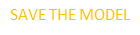

In [ ]:
model.save('/content/drive/MyDrive/403-WORKSHOP_DNNs for Map Generation_GEOSPATIAL CONF 2023/STUDENT/model_simple_U-Net.h5')

In [21]:
print("Returned:", history)
print(history.history.keys())

Returned: <keras.callbacks.History object at 0x7f1ba2a223b0>
dict_keys(['loss', 'accuracy', 'recall', 'precision', 'val_loss', 'val_accuracy', 'val_recall', 'val_precision'])


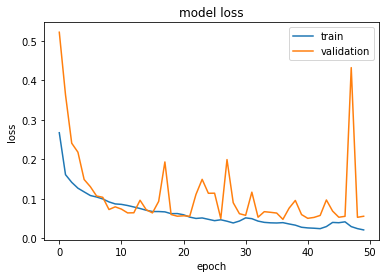

In [ ]:
 # "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right') 

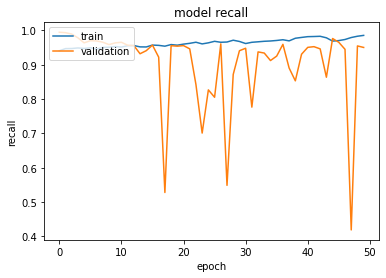

In [ ]:
#  "recall"
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

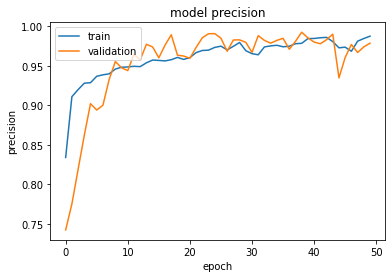

In [ ]:
#  "precision"
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')